In [1]:
import numpy as np
from matplotlib.colors import to_rgb
import biotite
from biotite.sequence import ProteinSequence
import biotite.structure as struc
import biotite.structure.io.mmtf as mmtf
import biotite.database.rcsb as rcsb
import ammolite


PNG_SIZE = (800, 800)
BACKBONE_ATOMS = ["N", "C", "O", "HA"]

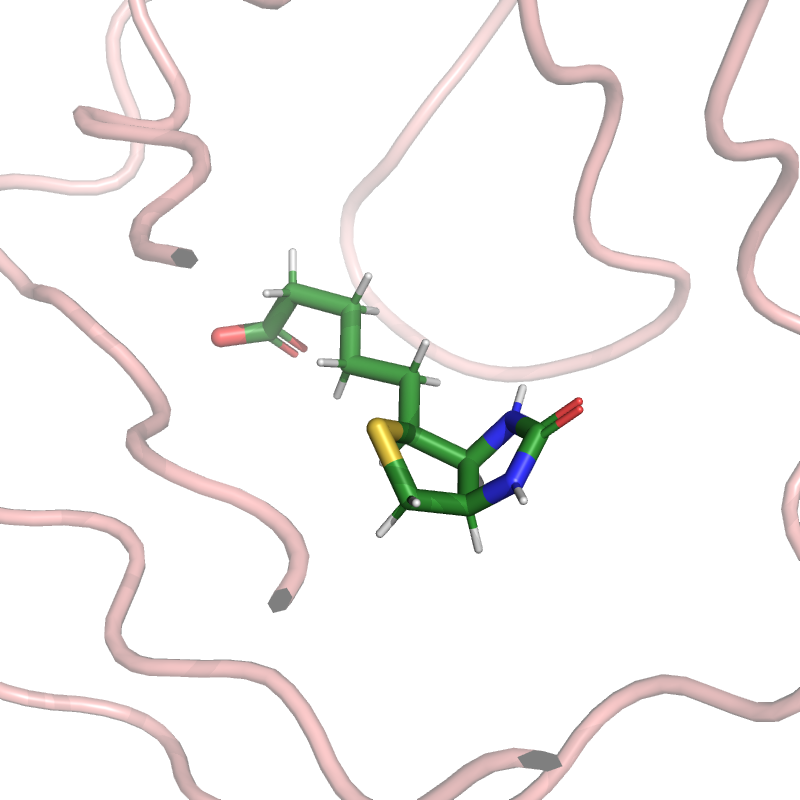

In [2]:
mmtf_file = mmtf.MMTFFile.read(rcsb.fetch("2RTG", "mmtf"))
structure = mmtf.get_structure(mmtf_file, model=1, include_bonds=True)
# Select one monomer of the dimer
structure = structure[structure.chain_id == structure.chain_id[0]]
# Remove water and ions
structure = structure[
    ~struc.filter_solvent(structure) &
    ~struc.filter_monoatomic_ions(structure)
]
strep_mask = struc.filter_amino_acids(structure)
biotin_mask = (structure.res_name == "BTN")

pymol_obj = ammolite.PyMOLObject.from_structure(structure)
pymol_obj.cartoon("loop", strep_mask)
pymol_obj.set("cartoon_transparency", 0.5)
pymol_obj.color("salmon", strep_mask & (structure.element == "C"))
pymol_obj.color("forest",    biotin_mask & (structure.element == "C"))
pymol_obj.zoom(biotin_mask, buffer=5.0)
ammolite.show(PNG_SIZE)

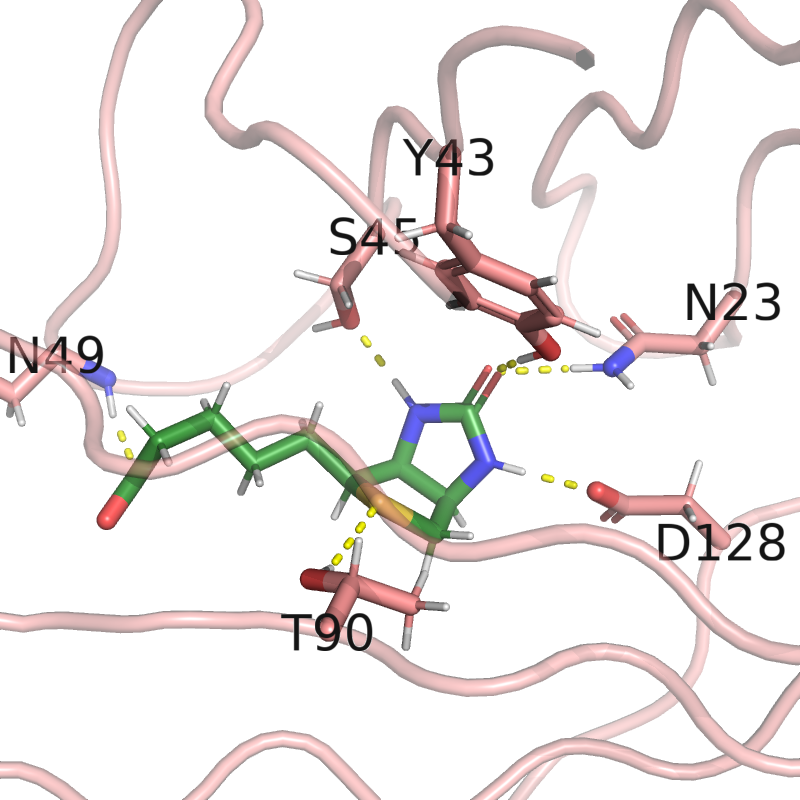

In [3]:
bonds = struc.hbond(structure, strep_mask, biotin_mask)

res_ids = []
for i, (donor, hydrogen, acceptor) in enumerate(bonds):
    # Highlight streptavidin residues bound to biotin
    if structure.res_name[donor] != "BTN":
        res_id = structure.res_id[donor]
        res_name = structure.res_name[donor]
    elif structure.res_name[acceptor] != "BTN":
        res_id = structure.res_id[acceptor]
        res_name = structure.res_name[acceptor]
    else:
        ValueError("The bond is not between streptavidin and biotin")
    res_ids.append(res_id)
    pymol_obj.show(
        "sticks",
         (structure.res_id == res_id) & ~np.isin(structure.atom_name, BACKBONE_ATOMS)
    )
    pymol_obj.label(
        (structure.res_id == res_id) & (structure.atom_name == "CA"),
        ProteinSequence.convert_letter_3to1(res_name) + str(res_id)
    )
    
    # Show all atoms involved in the bond, even if they are not part of
    # the residue (e.g. backbone atoms)
    pymol_obj.show(
        "sticks",
        [donor, hydrogen, acceptor] 
    )
    
    # Display hydrogen bonds
    pymol_obj.distance(f"bond_{i}", hydrogen, acceptor, show_label=False)

pymol_obj.orient(biotin_mask | np.isin(structure.res_id, res_ids))
ammolite.cmd.set("label_color", "black")
ammolite.cmd.set("label_size", 30)
ammolite.show(PNG_SIZE)